# Time series forecasting

# Initial setup

## Import required packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")

## Import time series data: Airline passenger traffic

In [2]:
data = pd.read_csv('UNRATE.csv', header = None)
data.columns = ['Year','Sales']
data['Year'] = pd.to_datetime(data['Year'], format='%d-%m-%Y')
data = data.set_index('Year')
data.head(12)

,Sales
Year,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
1948-06-01,3.6
1948-07-01,3.6
1948-08-01,3.9
1948-09-01,3.8


# Time series analysis

## Plot time series data

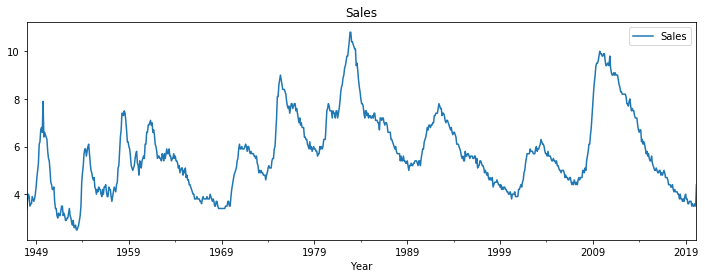

In [3]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales')
plt.show(block=False)

## Split time series data into training and test set

In [4]:
612
data.shape

(867, 1)

In [5]:
train_len = 612
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

### ADF Test

In [6]:
from statsmodels.tsa.stattools import adfuller
adf_test=adfuller(data['Sales'])
print('ADF statitistic: %f '%adf_test[0])
print("Critical value @ 0.05: %.2f"%adf_test[4]['5%'])
print('P-Value: %f' %adf_test[1])

ADF statitistic: -3.143963 
Critical value @ 0.05: -2.86
P-Value: 0.023466


### KPSS test

In [7]:
from statsmodels.tsa.stattools import kpss
kpss_test=kpss(data['Sales'])
print('kpss statitistic: %f '%kpss_test[0])
print("Critical value @ 0.05: %.2f"%kpss_test[3]['5%'])
print('P-Value: %f' %kpss_test[1])

kpss statitistic: 0.464446 
Critical value @ 0.05: 0.46
P-Value: 0.049674


### Boxcox Transformation

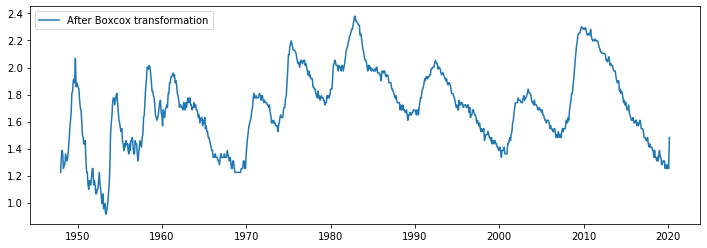

In [8]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Sales'],lmbda=0),index=data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox,label='After Boxcox transformation')
plt.legend(loc='best')
plt.show()


### Differencing

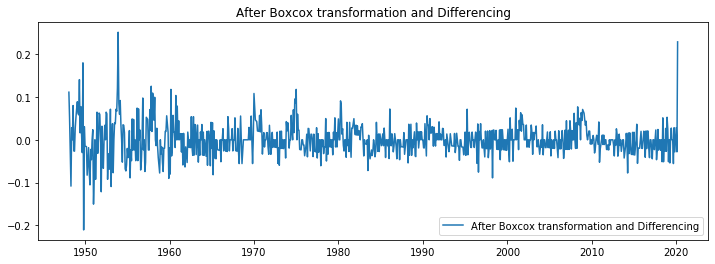

In [9]:
data_boxcox_diff=pd.Series(data_boxcox-data_boxcox.shift(),index=data.index)
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff,label='After Boxcox transformation and Differencing')
plt.legend(loc='best')
plt.title("After Boxcox transformation and Differencing")
plt.show()

### Autocorrelation function (ACF) plot

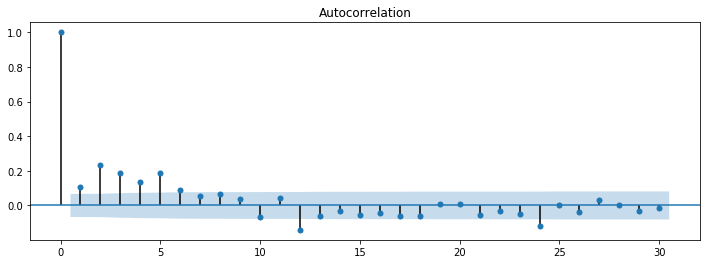

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff,ax=plt.gca(),lags=30)
plt.show()

### Partial Autocorrelation function (PACF) plot


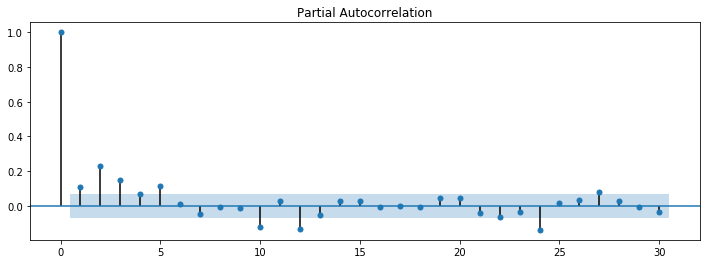

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff,ax=plt.gca(),lags=30)
plt.show()

### Split into train and test data sets

In [12]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

### Auto Regression Method (AR)

In [13]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff,order = (12,0,0))
model_fit=model.fit()
print(model_fit.summary())

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  611
Model:                    ARMA(12, 0)   Log Likelihood                1124.450
Method:                       css-mle   S.D. of innovations              0.038
Date:                Sat, 02 May 2020   AIC                          -2220.899
Time:                        13:55:22   BIC                          -2159.088
Sample:                    02-01-1948   HQIC                         -2196.857
                         - 12-01-1998                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.201      0.841      -0.004       0.005
ar.L1.y        0.0607      0.040      1.504      0.133      -0.018       0.140
ar.L2.y        0.1612      0.040      3.982      0.0

### Recover original time series forecast

In [2]:
model_fit

In [14]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

In [15]:
y_hat_ar['ar_forecast_boxcox']

1948-02-01    1.361443
1948-03-01    1.376477
1948-04-01    1.406784
1948-05-01    1.432227
1948-06-01    1.437511
1948-07-01    1.430085
1948-08-01    1.423514
1948-09-01    1.412478
1948-10-01    1.414227
1948-11-01    1.421789
1948-12-01    1.409657
1949-01-01    1.414709
1949-02-01    1.415609
1949-03-01    1.440904
1949-04-01    1.473675
1949-05-01    1.528145
1949-06-01    1.553966
1949-07-01    1.606762
1949-08-01    1.633630
1949-09-01    1.668067
1949-10-01    1.695504
1949-11-01    1.703881
1949-12-01    1.709475
1950-01-01    1.688754
1950-02-01    1.662865
1950-03-01    1.641597
1950-04-01    1.616151
1950-05-01    1.571288
1950-06-01    1.561632
1950-07-01    1.525524
                ...   
2017-10-01    1.744733
2017-11-01    1.745199
2017-12-01    1.745666
2018-01-01    1.746132
2018-02-01    1.746598
2018-03-01    1.747065
2018-04-01    1.747531
2018-05-01    1.747997
2018-06-01    1.748464
2018-07-01    1.748930
2018-08-01    1.749396
2018-09-01    1.749863
2018-10-01 

### Plot train,test and forecast

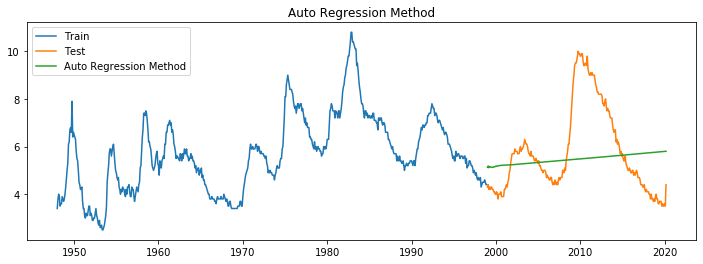

In [16]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto Regression Method')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [17]:
y_hat_ar['ar_forecast']

1948-02-01    3.901819
1948-03-01    3.960922
1948-04-01    4.082803
1948-05-01    4.188014
1948-06-01    4.210204
1948-07-01    4.179055
1948-08-01    4.151684
1948-09-01    4.106119
1948-10-01    4.113307
1948-11-01    4.144530
1948-12-01    4.094550
1949-01-01    4.115291
1949-02-01    4.118995
1949-03-01    4.224511
1949-04-01    4.365248
1949-05-01    4.609619
1949-06-01    4.730192
1949-07-01    4.986640
1949-08-01    5.122435
1949-09-01    5.301910
1949-10-01    5.449389
1949-11-01    5.495232
1949-12-01    5.526059
1950-01-01    5.412730
1950-02-01    5.274401
1950-03-01    5.163407
1950-04-01    5.033681
1950-05-01    4.812845
1950-06-01    4.766596
1950-07-01    4.597554
                ...   
2017-10-01    5.724373
2017-11-01    5.727044
2017-12-01    5.729715
2018-01-01    5.732387
2018-02-01    5.735061
2018-03-01    5.737736
2018-04-01    5.740413
2018-05-01    5.743090
2018-06-01    5.745769
2018-07-01    5.748449
2018-08-01    5.751131
2018-09-01    5.753813
2018-10-01 

### Calculate RMSE and MAPE

In [18]:
rmse = np.sqrt(mean_squared_error(test['Sales'],y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Auto Regressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
tempResults

,Method,RMSE,MAPE
0,Auto Regressive (AR) method,1.83,23.62


### Moving Average Method (MA)

In [25]:
model = ARIMA(train_data_boxcox_diff,order = (0,0,5))
model_fit=model.fit()
print(model_fit.params)

const      0.000507
ma.L1.y    0.055504
ma.L2.y    0.181882
ma.L3.y    0.123451
ma.L4.y    0.099834
ma.L5.y    0.151700
dtype: float64


//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


### Recover original time series forecast

In [26]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] =y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plot train,test and forecast

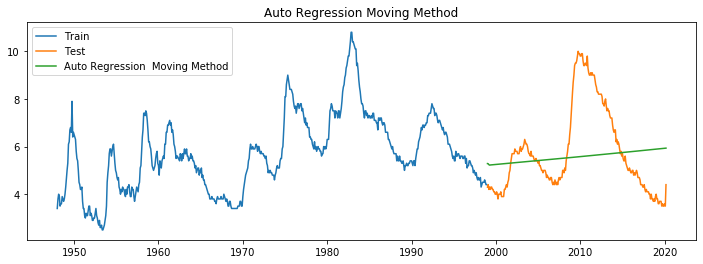

In [27]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Auto Regression  Moving Method')
plt.legend(loc='best')
plt.title('Auto Regression Moving Method')
plt.show()

### Calculate RMSE and MAPE

In [29]:
y_hat_ma['ma_forecast']

1948-02-01    3.901980
1948-03-01    3.950280
1948-04-01    4.057868
1948-05-01    4.143129
1948-06-01    4.141527
1948-07-01    4.109965
1948-08-01    4.074681
1948-09-01    4.034847
1948-10-01    4.035718
1948-11-01    4.084505
1948-12-01    4.102314
1949-01-01    4.161209
1949-02-01    4.198595
1949-03-01    4.277789
1949-04-01    4.414816
1949-05-01    4.561282
1949-06-01    4.716618
1949-07-01    4.903868
1949-08-01    5.013272
1949-09-01    5.113709
1949-10-01    5.195431
1949-11-01    5.200197
1949-12-01    5.292469
1950-01-01    5.171886
1950-02-01    5.100280
1950-03-01    5.137236
1950-04-01    4.981139
1950-05-01    4.961436
1950-06-01    4.895105
1950-07-01    4.809551
                ...   
2017-10-01    5.847126
2017-11-01    5.850094
2017-12-01    5.853064
2018-01-01    5.856034
2018-02-01    5.859007
2018-03-01    5.861981
2018-04-01    5.864956
2018-05-01    5.867933
2018-06-01    5.870911
2018-07-01    5.873891
2018-08-01    5.876872
2018-09-01    5.879855
2018-10-01 

In [28]:
rmse = np.sqrt(mean_squared_error(test['Sales'],y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ma['ma_forecast'][test.index.min():])/test['Sales'])*100,2)

results = pd.DataFrame({'Method':['Auto Regressive Moving (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Auto Regressive Moving (MA) method,1.82,24.26
0,Seasonal Auto Regressive Integrated Moving Ave...,2.34,23.05


### Auto Regressive Moving Average Method (ARMA)

In [40]:
model = ARIMA(train_data_boxcox_diff,order = (12,0,0))
model_fit=model.fit()
print(model_fit.params)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const       0.000466
ar.L1.y     0.060690
ar.L2.y     0.161198
ar.L3.y     0.118645
ar.L4.y     0.090456
ar.L5.y     0.107080
ar.L6.y     0.008286
ar.L7.y    -0.029413
ar.L8.y     0.032449
ar.L9.y     0.006198
ar.L10.y   -0.124660
ar.L11.y    0.047125
ar.L12.y   -0.148534
dtype: float64


### Recover original time series forecast

In [41]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum() 
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot train,test and forecast

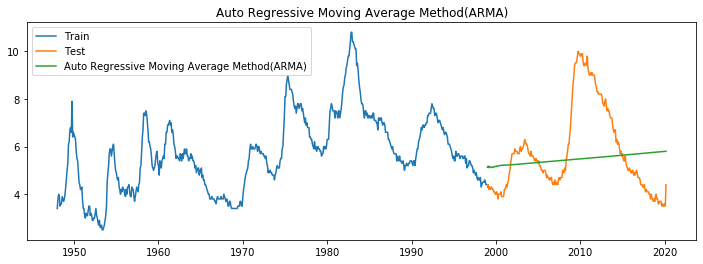

In [42]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='Auto Regressive Moving Average Method(ARMA)')
plt.legend(loc='best')
plt.title('Auto Regressive Moving Average Method(ARMA)')
plt.show()

### Calculate RMSE and MAPE

In [43]:
rmse = np.sqrt(mean_squared_error(test['Sales'],y_hat_arma['arma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arma['arma_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Auto Regressive Moving Average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Auto Regressive Integrated Moving Average (ARI...,1.85,23.00
0,Seasonal Auto Regressive Integrated Moving Ave...,2.34,23.05
0,Auto Regressive Moving Average (ARMA) method,1.83,23.62


### Auto Regressive Integrated  Moving Average Method (ARIMA)

In [21]:
model = ARIMA(train_data_boxcox,order = (12,1,5))
model_fit=model.fit()
print(model_fit.params)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const         0.000439
ar.L1.D.y    -0.099288
ar.L2.D.y     0.674421
ar.L3.D.y     0.488588
ar.L4.D.y    -0.473275
ar.L5.D.y    -0.597241
ar.L6.D.y     0.050358
ar.L7.D.y     0.049883
ar.L8.D.y     0.098677
ar.L9.D.y     0.137190
ar.L10.D.y   -0.048179
ar.L11.D.y    0.005494
ar.L12.D.y   -0.070606
ma.L1.D.y     0.130045
ma.L2.D.y    -0.514782
ma.L3.D.y    -0.363003
ma.L4.D.y     0.523413
ma.L5.D.y     0.664629
dtype: float64


//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Recover original time series forecast

In [22]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum() 
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot train,test and forecast

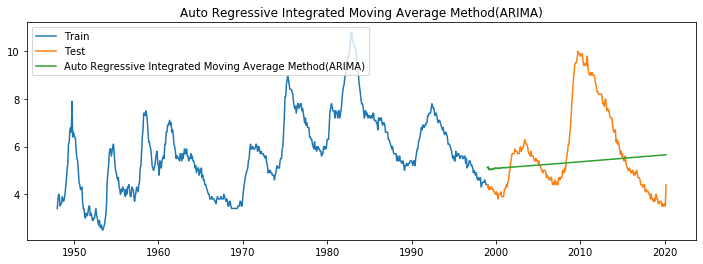

In [23]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='Auto Regressive Integrated Moving Average Method(ARIMA)')
plt.legend(loc='best')
plt.title('Auto Regressive Integrated Moving Average Method(ARIMA)')
plt.show()

### Calculate RMSE and MAPE

In [25]:
rmse = np.sqrt(mean_squared_error(test['Sales'],y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Auto Regressive Integrated Moving Average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
#results = pd.concat([ tempResults])
results = tempResults[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Auto Regressive Integrated Moving Average (ARI...,1.85,23.0


### Seasonal Auto Regressive Integrated Moving Average(SARIMA)

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_data_boxcox,order = (2,1,4),seasonal_order = (2,1,4,12))
model_fit=model.fit()
print(model_fit.params)

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ar.L1       0.572972
ar.L2       0.171230
ma.L1      -0.557520
ma.L2      -0.030698
ma.L3       0.077734
ma.L4       0.034899
ar.S.L12   -0.883745
ar.S.L24   -0.501693
ma.S.L12   -0.320469
ma.S.L24   -0.474176
ma.S.L36   -0.410384
ma.S.L48    0.266964
sigma2      0.001507
dtype: float64


### Recover original time series forecast

In [31]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train,test and forecast

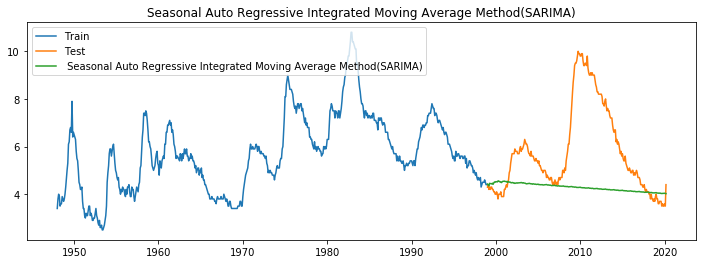

In [32]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label=' Seasonal Auto Regressive Integrated Moving Average Method(SARIMA)')
plt.legend(loc='best')
plt.title('Seasonal Auto Regressive Integrated Moving Average Method(SARIMA)')
plt.show()

### Calculate RMSE and MAPE

In [33]:
rmse = np.sqrt(mean_squared_error(test['Sales'],y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal Auto Regressive Integrated Moving Average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
#results = pd.concat([results, tempResults])
results = tempResults[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Seasonal Auto Regressive Integrated Moving Ave...,2.34,23.05
